# MLP
MLP_205 showed better performance with K=5 than K=4.

Here, try K=6.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-28 13:26:45.686640


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=6
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 13:27:18.320349
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262272    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 270,657
Trainable params: 270,657
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 13:27:18.951060
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-28 13:27:42.232962

Training # 1 1
2023-03-28 13:27:42.233313
2023-03-28 13:27:42.233383
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-28 13:27:42.416082


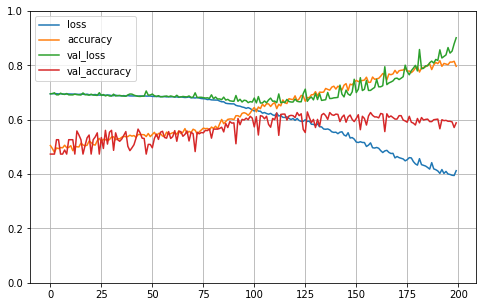


2023-03-28 13:30:05.965989

Testing # 1 1
2023-03-28 13:30:05.966123
2023-03-28 13:30:05.966191
PREDICT
2023-03-28 13:30:05.986061
Test 1:0 458:412 52.64%
Predict 1:0 624:246 71.72%
Test sizes (870, 4097) (870,)
Range of scores: 0.0011915943 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[150 262]
 [ 96 362]]
Normalized matrix
 [[0.17241379 0.30114943]
 [0.11034483 0.41609195]]


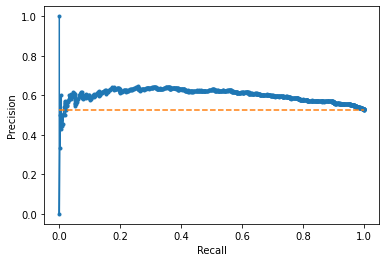

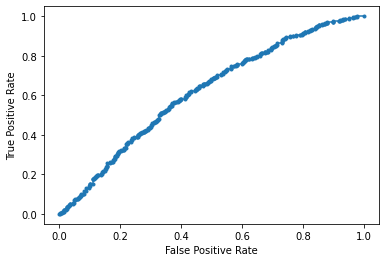

Accuracy: 58.85% Precision: 58.01% Recall: 79.04%
F1: 66.91% MCC: 0.1713
AUPRC: 60.10% AUROC: 61.76%
 accuracy [58.85057471264368]
 precision [58.01282051282052]
 recall [79.03930131004367]
 F1 [66.91312384473197]
 MCC [0.17126458457022709]
 AUPRC [60.097974911518214]
 AUROC [61.75753593080934]
2023-03-28 13:30:07.265655

Training # 1 2
2023-03-28 13:30:07.265821
2023-03-28 13:30:07.265856
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-28 13:30:07.392389


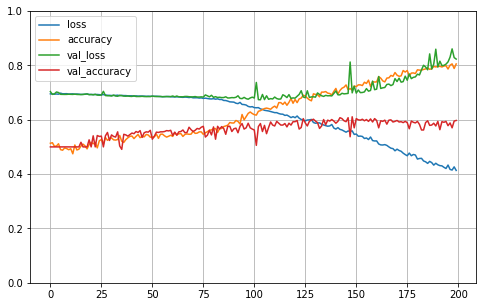


2023-03-28 13:32:33.994155

Testing # 1 2
2023-03-28 13:32:33.994258
2023-03-28 13:32:33.994295
PREDICT
2023-03-28 13:32:34.013250
Test 1:0 442:442 50.00%
Predict 1:0 502:382 56.79%
Test sizes (884, 4097) (884,)
Range of scores: 0.000104656494 to 0.99999505
Score threshold 0.5
Confusion matrix
 [[234 208]
 [148 294]]
Normalized matrix
 [[0.26470588 0.23529412]
 [0.16742081 0.33257919]]


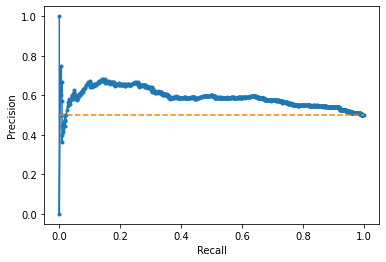

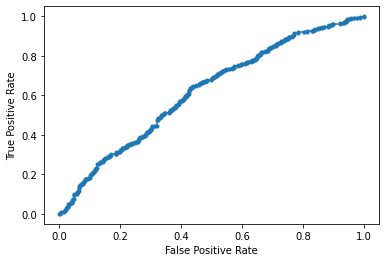

Accuracy: 59.73% Precision: 58.57% Recall: 66.52%
F1: 62.29% MCC: 0.1964
AUPRC: 58.91% AUROC: 61.99%
 accuracy [59.72850678733032]
 precision [58.56573705179283]
 recall [66.51583710407239]
 F1 [62.28813559322034]
 MCC [0.1963879836662398]
 AUPRC [58.913097703487495]
 AUROC [61.99350955140148]
2023-03-28 13:32:34.976357

Training # 1 3
2023-03-28 13:32:34.978011
2023-03-28 13:32:34.978349
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-28 13:32:35.095627


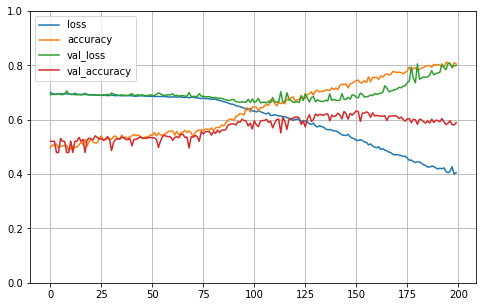


2023-03-28 13:35:58.274944

Testing # 1 3
2023-03-28 13:35:58.275083
2023-03-28 13:35:58.275135
PREDICT
2023-03-28 13:35:58.290624
Test 1:0 442:407 52.06%
Predict 1:0 443:406 52.18%
Test sizes (849, 4097) (849,)
Range of scores: 0.00020186501 to 0.9992597
Score threshold 0.5
Confusion matrix
 [[232 175]
 [174 268]]
Normalized matrix
 [[0.27326266 0.20612485]
 [0.204947   0.31566549]]


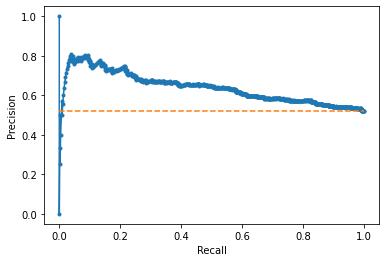

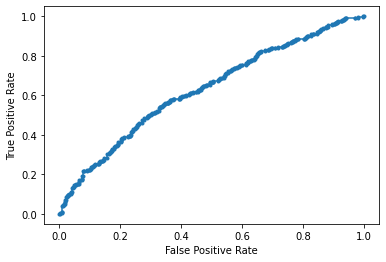

Accuracy: 58.89% Precision: 60.50% Recall: 60.63%
F1: 60.56% MCC: 0.1764
AUPRC: 63.83% AUROC: 63.08%
 accuracy [58.89281507656066]
 precision [60.496613995485326]
 recall [60.633484162895925]
 F1 [60.56497175141242]
 MCC [0.1763770606353754]
 AUPRC [63.83436338315763]
 AUROC [63.08103661044837]
2023-03-28 13:35:59.375858

Training # 1 4
2023-03-28 13:35:59.378253
2023-03-28 13:35:59.378341
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-28 13:35:59.513206


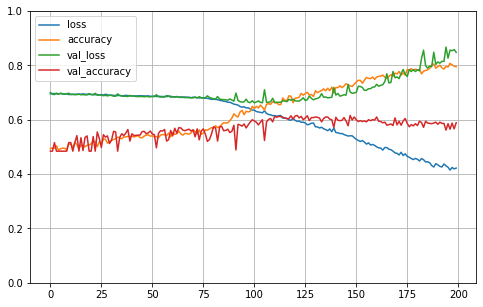


2023-03-28 13:38:24.306065

Testing # 1 4
2023-03-28 13:38:24.306509
2023-03-28 13:38:24.306597
PREDICT
2023-03-28 13:38:24.348870
Test 1:0 459:431 51.57%
Predict 1:0 569:321 63.93%
Test sizes (890, 4097) (890,)
Range of scores: 0.00045084473 to 0.998786
Score threshold 0.5
Confusion matrix
 [[193 238]
 [128 331]]
Normalized matrix
 [[0.21685393 0.26741573]
 [0.14382022 0.37191011]]


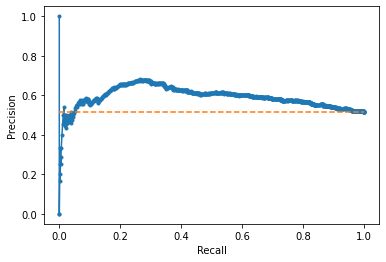

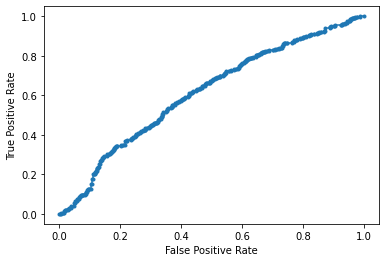

Accuracy: 58.88% Precision: 58.17% Recall: 72.11%
F1: 64.40% MCC: 0.1758
AUPRC: 58.95% AUROC: 61.36%
 accuracy [58.876404494382015]
 precision [58.17223198594025]
 recall [72.1132897603486]
 F1 [64.39688715953308]
 MCC [0.17580848159123996]
 AUPRC [58.94581200029134]
 AUROC [61.35500861855441]
2023-03-28 13:38:25.427551

Training # 1 5
2023-03-28 13:38:25.430272
2023-03-28 13:38:25.430870
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-28 13:38:25.698151


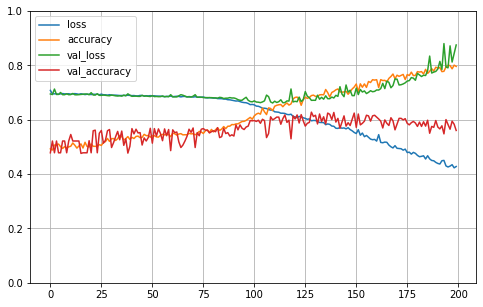


2023-03-28 13:41:49.539654

Testing # 1 5
2023-03-28 13:41:49.540053
2023-03-28 13:41:49.540113
PREDICT
2023-03-28 13:41:49.558874
Test 1:0 457:419 52.17%
Predict 1:0 248:628 28.31%
Test sizes (876, 4097) (876,)
Range of scores: 0.0002613338 to 0.997708
Score threshold 0.5
Confusion matrix
 [[331  88]
 [297 160]]
Normalized matrix
 [[0.37785388 0.10045662]
 [0.3390411  0.1826484 ]]


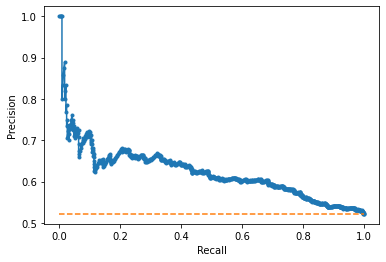

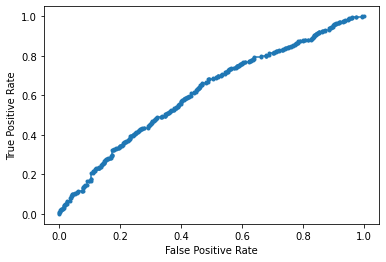

Accuracy: 56.05% Precision: 64.52% Recall: 35.01%
F1: 45.39% MCC: 0.1553
AUPRC: 62.28% AUROC: 61.45%
 accuracy [56.050228310502284]
 precision [64.51612903225806]
 recall [35.010940919037196]
 F1 [45.39007092198582]
 MCC [0.15532907880319655]
 AUPRC [62.28077723745184]
 AUROC [61.44514134414021]
2023-03-28 13:41:50.756350

Training # 2 1
2023-03-28 13:41:50.757714
2023-03-28 13:41:50.757779
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-28 13:41:50.877998


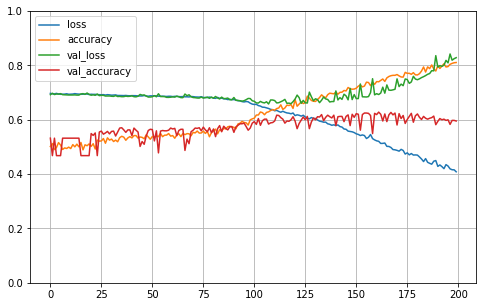


2023-03-28 13:44:14.195924

Testing # 2 1
2023-03-28 13:44:14.196016
2023-03-28 13:44:14.196054
PREDICT
2023-03-28 13:44:14.212813
Test 1:0 472:415 53.21%
Predict 1:0 455:432 51.30%
Test sizes (887, 4097) (887,)
Range of scores: 0.0012646044 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[244 171]
 [188 284]]
Normalized matrix
 [[0.27508455 0.19278467]
 [0.21195039 0.32018038]]


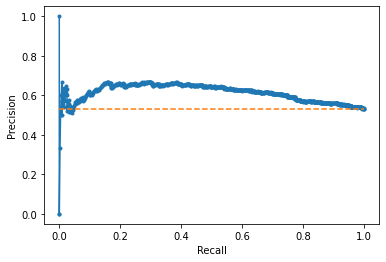

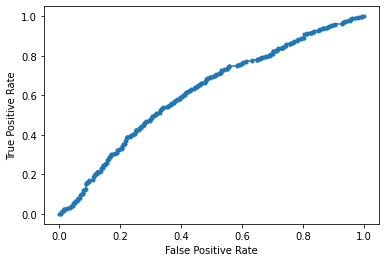

Accuracy: 59.53% Precision: 62.42% Recall: 60.17%
F1: 61.27% MCC: 0.1893
AUPRC: 61.29% AUROC: 61.94%
 accuracy [59.52649379932357]
 precision [62.417582417582416]
 recall [60.16949152542372]
 F1 [61.272923408845735]
 MCC [0.18931839652968607]
 AUPRC [61.2855886391317]
 AUROC [61.94353685930161]
2023-03-28 13:44:15.350939

Training # 2 2
2023-03-28 13:44:15.352192
2023-03-28 13:44:15.352277
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-28 13:44:15.470578


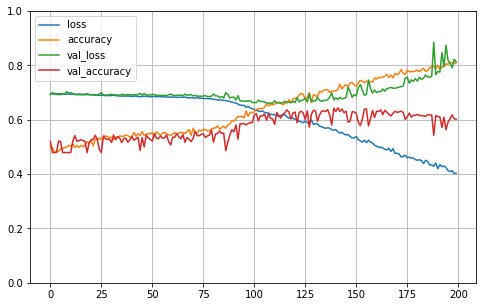


2023-03-28 13:47:38.747933

Testing # 2 2
2023-03-28 13:47:38.748036
2023-03-28 13:47:38.748085
PREDICT
2023-03-28 13:47:38.765854
Test 1:0 452:416 52.07%
Predict 1:0 374:494 43.09%
Test sizes (868, 4097) (868,)
Range of scores: 0.00019326476 to 0.9996183
Score threshold 0.5
Confusion matrix
 [[282 134]
 [212 240]]
Normalized matrix
 [[0.32488479 0.15437788]
 [0.24423963 0.2764977 ]]


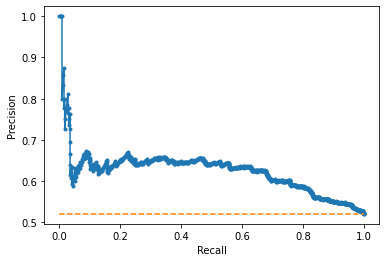

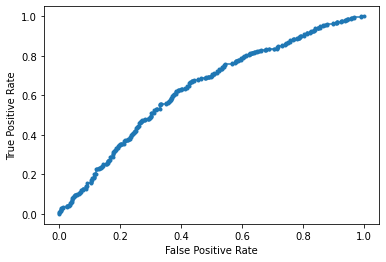

Accuracy: 60.14% Precision: 64.17% Recall: 53.10%
F1: 58.11% MCC: 0.2107
AUPRC: 62.60% AUROC: 63.54%
 accuracy [60.13824884792627]
 precision [64.1711229946524]
 recall [53.09734513274337]
 F1 [58.111380145278446]
 MCC [0.2107016132437699]
 AUPRC [62.60154929418411]
 AUROC [63.54397123893805]
2023-03-28 13:47:40.024363

Training # 2 3
2023-03-28 13:47:40.027062
2023-03-28 13:47:40.027570
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-28 13:47:40.176496


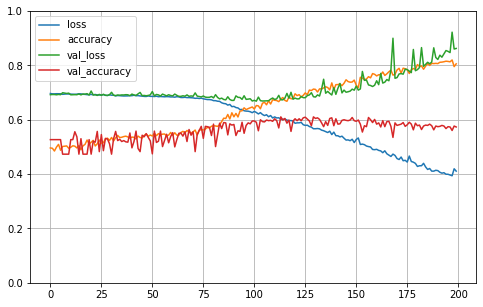


2023-03-28 13:50:05.894566

Testing # 2 3
2023-03-28 13:50:05.894699
2023-03-28 13:50:05.894750
PREDICT
2023-03-28 13:50:05.912760
Test 1:0 453:407 52.67%
Predict 1:0 532:328 61.86%
Test sizes (860, 4097) (860,)
Range of scores: 6.450277e-05 to 0.9976615
Score threshold 0.5
Confusion matrix
 [[184 223]
 [144 309]]
Normalized matrix
 [[0.21395349 0.25930233]
 [0.16744186 0.35930233]]


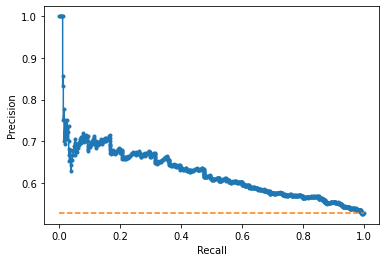

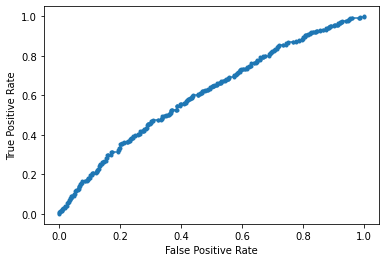

Accuracy: 57.33% Precision: 58.08% Recall: 68.21%
F1: 62.74% MCC: 0.1380
AUPRC: 62.39% AUROC: 60.86%
 accuracy [57.325581395348834]
 precision [58.08270676691729]
 recall [68.21192052980133]
 F1 [62.74111675126903]
 MCC [0.13795290916966618]
 AUPRC [62.3938332165922]
 AUROC [60.85881185218933]
2023-03-28 13:50:06.863089

Training # 2 4
2023-03-28 13:50:06.863963
2023-03-28 13:50:06.864025
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-28 13:50:06.985817


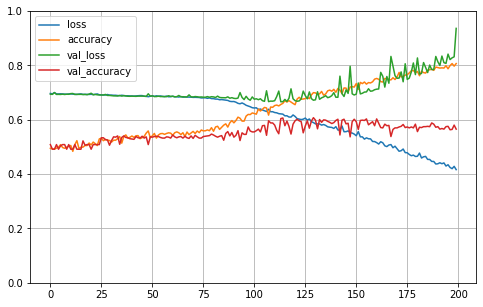


2023-03-28 13:52:38.931180

Testing # 2 4
2023-03-28 13:52:38.931619
2023-03-28 13:52:38.931688
PREDICT
2023-03-28 13:52:38.949878
Test 1:0 432:447 49.15%
Predict 1:0 198:681 22.53%
Test sizes (879, 4097) (879,)
Range of scores: 3.345516e-05 to 0.9770384
Score threshold 0.5
Confusion matrix
 [[373  74]
 [308 124]]
Normalized matrix
 [[0.42434585 0.08418658]
 [0.35039818 0.1410694 ]]


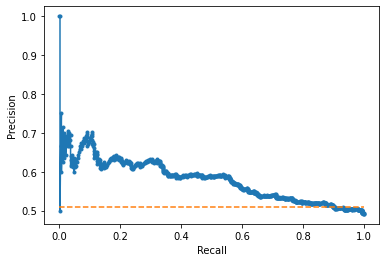

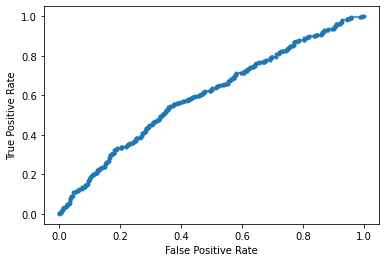

Accuracy: 56.54% Precision: 62.63% Recall: 28.70%
F1: 39.37% MCC: 0.1454
AUPRC: 57.98% AUROC: 59.97%
 accuracy [56.5415244596132]
 precision [62.62626262626263]
 recall [28.703703703703702]
 F1 [39.36507936507937]
 MCC [0.14538721644719454]
 AUPRC [57.98074341195291]
 AUROC [59.968721517938526]
2023-03-28 13:52:39.983963

Training # 2 5
2023-03-28 13:52:39.986457
2023-03-28 13:52:39.986577
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-28 13:52:40.119787


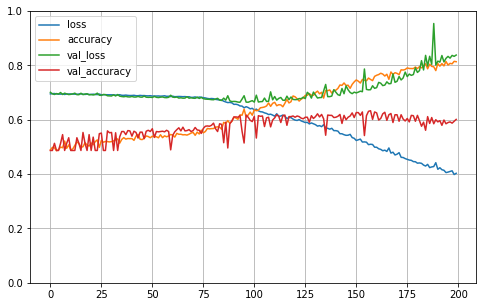


2023-03-28 13:56:03.484930

Testing # 2 5
2023-03-28 13:56:03.485071
2023-03-28 13:56:03.485129
PREDICT
2023-03-28 13:56:03.502555
Test 1:0 449:426 51.31%
Predict 1:0 512:363 58.51%
Test sizes (875, 4097) (875,)
Range of scores: 0.00067283167 to 0.99999976
Score threshold 0.5
Confusion matrix
 [[220 206]
 [143 306]]
Normalized matrix
 [[0.25142857 0.23542857]
 [0.16342857 0.34971429]]


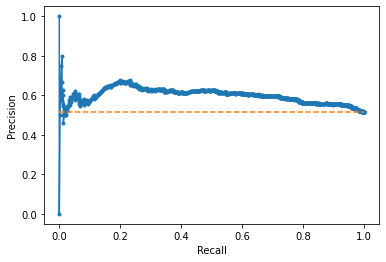

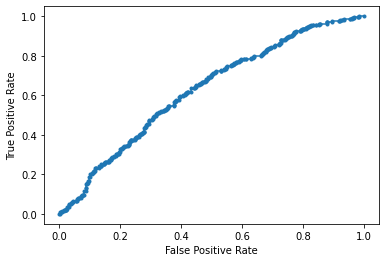

Accuracy: 60.11% Precision: 59.77% Recall: 68.15%
F1: 63.68% MCC: 0.2008
AUPRC: 59.89% AUROC: 62.72%
 accuracy [60.11428571428571]
 precision [59.765625]
 recall [68.15144766146993]
 F1 [63.68366285119668]
 MCC [0.2008109025465156]
 AUPRC [59.88826000243598]
 AUROC [62.71840396499263]
2023-03-28 13:56:04.190905


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.60% std 1.47
 precision mean 60.68% std 2.56
 recall mean 59.16% std 16.09
 F1 mean 58.47% std 8.91
 MCC mean 0.18% std 0.02
 AUPRC mean 60.82% std 1.93
 AUROC mean 61.87% std 1.06
 accuracy [[58.85057471264368], [59.72850678733032], [58.89281507656066], [58.876404494382015], [56.050228310502284], [59.52649379932357], [60.13824884792627], [57.325581395348834], [56.5415244596132], [60.11428571428571]]
 precision [[58.01282051282052], [58.56573705179283], [60.496613995485326], [58.17223198594025], [64.51612903225806], [62.417582417582416], [64.1711229946524], [58.08270676691729], [62.62626262626263], [59.765625]]
 recall [[79.03930131004367], [66.51583710407239], [60.633484162895925], [72.1132897603486], [35.010940919037196], [60.16949152542372], [53.09734513274337], [68.21192052980133], [28.703703703703702], [68.15144766146993]]
 F1 [[66.91312384473197], [62.28813559322034], [60.56497175141242], [64.39688715953308], [45.39007092198582], [61.272923408845735], [58.111380